# LPFormer: An Adaptive Graph Transformer for Link Prediction

This notebook implements the LPFormer model as described in the paper "LPFormer: An Adaptive Graph Transformer for Link Prediction" (Shomer et al., 2024), applied to the Marvel Universe dataset. The implementation includes all components described in the paper:

1. GCN-based node representation learning
2. PPR-based relative positional encodings with order invariance
3. GATv2 attention mechanism for adaptive pairwise encoding
4. Efficient node selection via PPR thresholding using Andersen's algorithm
5. Proper evaluation metrics as specified in the paper
6. LP factor analysis for performance evaluation

The implementation is optimized for GPU execution.

## 1. Setup and Dependencies

In [1]:
# Install core PyTorch (with CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric and dependencies for CUDA 11.8
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

# Install other required packages
!pip install numpy pandas scipy matplotlib networkx tqdm scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.utils import to_undirected, add_self_loops, degree
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import scipy.sparse as sp
from scipy.sparse.linalg import norm as sparse_norm
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_cluster/_version_cud

Using device: cuda


## 2. Marvel Dataset Loading and Processing

We load and process the Marvel Universe dataset, which consists of connections between heroes and comics.

In [3]:
print("Loading Marvel dataset...")
start_time = time.time()

# Load the Marvel dataset
edges_df = pd.read_csv('edges_corr.csv')
nodes_df = pd.read_csv('nodes_corr.csv')

print(f"Dataset loaded in {time.time() - start_time:.2f} seconds")
print(f"Edges shape: {edges_df.shape}")
print(f"Nodes shape: {nodes_df.shape}")

# Display first few rows of each dataset
print("\nEdges preview:")
display(edges_df.head())

print("\nNodes preview:")
display(nodes_df.head())

# Check for missing values
print("\nMissing values in edges:", edges_df.isnull().sum().sum())
print("Missing values in nodes:", nodes_df.isnull().sum().sum())

# Summary statistics
print("\nUnique heroes:", edges_df['hero'].nunique())
print("Unique comics:", edges_df['comic'].nunique())
print("Node types:", nodes_df['type'].unique())
print("Node type counts:")
display(nodes_df['type'].value_counts())

Loading Marvel dataset...
Dataset loaded in 0.09 seconds
Edges shape: (96104, 2)
Nodes shape: (19090, 2)

Edges preview:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Nodes preview:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Missing values in edges: 0
Missing values in nodes: 0

Unique heroes: 6439
Unique comics: 12651
Node types: ['comic' 'hero']
Node type counts:


type
comic    12651
hero      6439
Name: count, dtype: int64

In [4]:
print("Processing Marvel dataset...")
start_time = time.time()

# Encode node IDs to indices
node_encoder = LabelEncoder()
nodes_df['node_idx'] = node_encoder.fit_transform(nodes_df['node'])

# Create a mapping from node names to indices
node_to_idx = {node: idx for node, idx in zip(nodes_df['node'], nodes_df['node_idx'])}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

# Map edges to node indices
edges_df['hero_idx'] = edges_df['hero'].map(node_to_idx)
edges_df['comic_idx'] = edges_df['comic'].map(node_to_idx)

# Check for mapping failures (NaN values)
missing_heroes = edges_df[edges_df['hero'].map(lambda x: x not in node_to_idx)]
missing_comics = edges_df[edges_df['comic'].map(lambda x: x not in node_to_idx)]

if len(missing_heroes) > 0 or len(missing_comics) > 0:
    print(f"Warning: Found {len(missing_heroes)} heroes and {len(missing_comics)} comics missing from nodes_df")
    # Filter out edges with missing nodes
    edges_df = edges_df[edges_df['hero'].map(lambda x: x in node_to_idx) & 
                        edges_df['comic'].map(lambda x: x in node_to_idx)]
    # Recalculate indices
    edges_df['hero_idx'] = edges_df['hero'].map(node_to_idx)
    edges_df['comic_idx'] = edges_df['comic'].map(node_to_idx)

# Create edge index tensor
edge_index = torch.tensor([edges_df['hero_idx'].values.astype(np.int64), 
                          edges_df['comic_idx'].values.astype(np.int64)], dtype=torch.long)

# Make the graph undirected for link prediction
edge_index = to_undirected(edge_index)

# Create node type encoding
nodes_df['type_idx'] = nodes_df['type'].map({'hero': 0, 'comic': 1})
node_types = torch.tensor(nodes_df['type_idx'].values, dtype=torch.long)

# Create node features
# 1. One-hot encoding for node type
type_features = F.one_hot(node_types, num_classes=2).float()

# 2. Add degree features (normalized)
row, col = edge_index
deg = degree(row, nodes_df.shape[0])
deg_normalized = deg / deg.max()
deg_features = deg_normalized.unsqueeze(1)

# Combine features
node_features = torch.cat([type_features, deg_features], dim=1)

# Create PyG Data object
data = Data(x=node_features, edge_index=edge_index)
data.num_nodes = nodes_df.shape[0]

print(f"Dataset processing completed in {time.time() - start_time:.2f} seconds")

# Display results
print(f"Node feature shape: {node_features.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.edge_index.size(1)}")

Processing Marvel dataset...
Dataset processing completed in 0.15 seconds
Node feature shape: torch.Size([19090, 3])
Edge index shape: torch.Size([2, 191654])
Number of nodes: 19090
Number of edges: 191654


In [5]:
print("Creating train/validation/test splits...")
start_time = time.time()

# Create train/validation/test splits
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0
)

train_data, val_data, test_data = transform(data)

# Move to GPU (or CPU fallback)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# Create split_edge dictionary
split_edge = {
    'train': {
        'edge': train_data.edge_label_index[:, train_data.edge_label == 1].t(),
        'edge_neg': train_data.edge_label_index[:, train_data.edge_label == 0].t()
    },
    'valid': {
        'edge': val_data.edge_label_index[:, val_data.edge_label == 1].t(),
        'edge_neg': val_data.edge_label_index[:, val_data.edge_label == 0].t()
    },
    'test': {
        'edge': test_data.edge_label_index[:, test_data.edge_label == 1].t(),
        'edge_neg': test_data.edge_label_index[:, test_data.edge_label == 0].t()
    }
}

print(f"Data splits created in {time.time() - start_time:.2f} seconds")

# Print split statistics
print(f"Train positive edges: {len(split_edge['train']['edge'])}")
print(f"Train negative edges: {len(split_edge['train']['edge_neg'])}")
print(f"Validation positive edges: {len(split_edge['valid']['edge'])}")
print(f"Validation negative edges: {len(split_edge['valid']['edge_neg'])}")
print(f"Test positive edges: {len(split_edge['test']['edge'])}")
print(f"Test negative edges: {len(split_edge['test']['edge_neg'])}")

Creating train/validation/test splits...
Data splits created in 0.48 seconds
Train positive edges: 76663
Train negative edges: 76663
Validation positive edges: 9582
Validation negative edges: 9582
Test positive edges: 9582
Test negative edges: 9582


## 3. PPR Computation using Andersen's Algorithm

We implement the efficient Personalized PageRank (PPR) computation using Andersen's algorithm as mentioned in the paper.

In [6]:
def compute_ppr_andersen(edge_index, alpha=0.15, eps=1e-5, num_nodes=None):
    """
    Compute Personalized PageRank (PPR) matrix using Andersen's algorithm.

    Args:
        edge_index: Edge index tensor [2, num_edges]
        alpha: Teleportation probability (default: 0.15)
        eps: Error tolerance (default: 1e-5)
        num_nodes: Number of nodes in the graph (optional)

    Returns:
        PPR matrix as a torch tensor [num_nodes, num_nodes]
    """
    if num_nodes is None:
        num_nodes = edge_index.max().item() + 1

    print(f"Computing PPR matrix for {num_nodes} nodes using Andersen's algorithm...")
    print(f"This may take a while for large graphs. Please be patient.")
    start_time = time.time()

    # Convert edge_index to scipy sparse matrix
    edge_list = edge_index.t().cpu().numpy()
    adj = sp.coo_matrix(
        (np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
        shape=(num_nodes, num_nodes),
        dtype=np.float32
    )

    # Make the adjacency matrix symmetric (undirected)
    adj = adj + adj.T
    adj = adj.tocsr()

    # Normalize the adjacency matrix by row
    rowsum = np.array(adj.sum(1))
    rowsum[rowsum == 0] = 1.0  # Avoid division by zero
    d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.0
    d_mat_inv = sp.diags(d_inv)
    norm_adj = d_mat_inv.dot(adj)

    # Initialize PPR matrix
    ppr_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    # Progress tracking variables
    last_update_time = time.time()
    update_interval = 5  # seconds

    # Compute PPR for each node using Andersen's algorithm
    for i in tqdm(range(num_nodes), desc="Computing PPR"):
        # Print progress update every few seconds
        current_time = time.time()
        if current_time - last_update_time > update_interval:
            elapsed = current_time - start_time
            progress = (i + 1) / num_nodes
            eta = elapsed / progress - elapsed if progress > 0 else 0
            print(f"Progress: {progress*100:.1f}% ({i+1}/{num_nodes}), Elapsed: {elapsed:.1f}s, ETA: {eta:.1f}s")
            last_update_time = current_time
            
        # Initialize residual and approximation vectors
        r = np.zeros(num_nodes)
        p = np.zeros(num_nodes)
        r[i] = 1.0

        # Push operation
        while np.max(r) > eps:
            # Find node with highest residual
            j = np.argmax(r)

            # Update approximation and residual
            p[j] += alpha * r[j]

            # Push residual to neighbors
            neighbors = norm_adj[j].nonzero()[1]
            if len(neighbors) > 0:  # Check if node has neighbors
                for k in neighbors:
                    r[k] += (1 - alpha) * r[j] * norm_adj[j, k] / len(neighbors)

            # Reset residual
            r[j] = 0

        # Store PPR vector for node i
        ppr_matrix[i] = p

    # Convert to torch tensor
    ppr_tensor = torch.FloatTensor(ppr_matrix)

    total_time = time.time() - start_time
    print(f"PPR matrix computation completed in {total_time:.2f} seconds!")
    return ppr_tensor

## 4. LPFormer Model Implementation

We implement the LPFormer model with all components as described in the paper, including GATv2 attention and order-invariant RPE.

In [7]:
class PPRThresholding(nn.Module):
    """
    Module for PPR-based thresholding to select nodes to attend to.
    Implements Equation (10) from the paper.
    """
    def __init__(self, ppr_matrix, cn_threshold=0.01, one_hop_threshold=0.001, multi_hop_threshold=0.0001):
        super(PPRThresholding, self).__init__()
        self.ppr_matrix = ppr_matrix
        self.cn_threshold = cn_threshold
        self.one_hop_threshold = one_hop_threshold
        self.multi_hop_threshold = multi_hop_threshold
        self.device = ppr_matrix.device

    def forward(self, a, b, adj_matrix):
        """
        Args:
            a, b: Indices of the two nodes in the target link
            adj_matrix: Adjacency matrix [num_nodes, num_nodes]

        Returns:
            Dictionary of filtered nodes by type (CN, 1-hop, >1-hop)
        """
        # Ensure indices are on the same device as the PPR matrix
        a = a.to(self.ppr_matrix.device)
        b = b.to(self.ppr_matrix.device)
        adj_matrix = adj_matrix.to(self.ppr_matrix.device)
        
        # Identify common neighbors (CN)
        cn_mask = (adj_matrix[a] == 1) & (adj_matrix[b] == 1)
        cn_nodes = torch.where(cn_mask)[0].to(self.ppr_matrix.device)

        # Identify 1-hop neighbors (connected to either a or b, but not both)
        one_hop_mask = ((adj_matrix[a] == 1) | (adj_matrix[b] == 1)) & (~cn_mask)
        one_hop_nodes = torch.where(one_hop_mask)[0].to(self.ppr_matrix.device)

        # Identify multi-hop neighbors (not connected to either a or b)
        multi_hop_mask = (adj_matrix[a] == 0) & (adj_matrix[b] == 0)
        multi_hop_mask[a] = False  # Exclude a and b
        multi_hop_mask[b] = False
        multi_hop_nodes = torch.where(multi_hop_mask)[0].to(self.ppr_matrix.device)

        # Apply PPR thresholding as per Equation (10)
        if len(cn_nodes) > 0:
            filtered_cn = cn_nodes[
                (self.ppr_matrix[a, cn_nodes] > self.cn_threshold) &
                (self.ppr_matrix[b, cn_nodes] > self.cn_threshold)
            ]
        else:
            filtered_cn = torch.tensor([], dtype=torch.long, device=self.ppr_matrix.device)
        
        if len(one_hop_nodes) > 0:
            filtered_one_hop = one_hop_nodes[
                (self.ppr_matrix[a, one_hop_nodes] > self.one_hop_threshold) |
                (self.ppr_matrix[b, one_hop_nodes] > self.one_hop_threshold)
            ]
        else:
            filtered_one_hop = torch.tensor([], dtype=torch.long, device=self.ppr_matrix.device)
        
        if len(multi_hop_nodes) > 0:
            filtered_multi_hop = multi_hop_nodes[
                (self.ppr_matrix[a, multi_hop_nodes] > self.multi_hop_threshold) |
                (self.ppr_matrix[b, multi_hop_nodes] > self.multi_hop_threshold)
            ]
        else:
            filtered_multi_hop = torch.tensor([], dtype=torch.long, device=self.ppr_matrix.device)

        return {
            'cn': filtered_cn,
            'one_hop': filtered_one_hop,
            'multi_hop': filtered_multi_hop
        }

In [8]:
class PPRPositionalEncoding(nn.Module):
    """
    Module for PPR-based relative positional encoding with order invariance.
    Implements Equations (7) and (8) from the paper.
    """
    def __init__(self, ppr_matrix, hidden_dim):
        super(PPRPositionalEncoding, self).__init__()
        self.ppr_matrix = ppr_matrix
        self.hidden_dim = hidden_dim
        self.device = ppr_matrix.device

        # Separate MLPs for different node types as mentioned in the paper
        self.cn_mlp = nn.Sequential(
            nn.Linear(2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim)
        )

        self.one_hop_mlp = nn.Sequential(
            nn.Linear(2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim)
        )

        self.multi_hop_mlp = nn.Sequential(
            nn.Linear(2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim)
        )

    def forward(self, a, b, nodes, node_types):
        """
        Args:
            a, b: Indices of the two nodes in the target link
            nodes: Tensor of node indices to compute RPE for
            node_types: List of node types ('cn', 'one_hop', 'multi_hop')

        Returns:
            Tensor of relative positional encodings [num_nodes, hidden_dim]
        """
        # Ensure indices are on the same device as the PPR matrix
        a = a.to(self.ppr_matrix.device)
        b = b.to(self.ppr_matrix.device)
        nodes = nodes.to(self.ppr_matrix.device)
        
        rpes = []

        for i, node in enumerate(nodes):
            # Get PPR scores
            node = node.to(self.ppr_matrix.device)
            ppr_a_u = self.ppr_matrix[a, node].item()
            ppr_b_u = self.ppr_matrix[b, node].item()

            # Create PPR feature vector
            ppr_features_ab = torch.tensor([ppr_a_u, ppr_b_u], dtype=torch.float32, device=self.ppr_matrix.device)
            ppr_features_ba = torch.tensor([ppr_b_u, ppr_a_u], dtype=torch.float32, device=self.ppr_matrix.device)

            # Apply appropriate MLP based on node type
            node_type = node_types[i]
            if node_type == 'cn':
                # Implement order invariance as per Equation (8)
                rpe_ab = self.cn_mlp(ppr_features_ab)
                rpe_ba = self.cn_mlp(ppr_features_ba)
                rpe = rpe_ab + rpe_ba
            elif node_type == 'one_hop':
                # Implement order invariance as per Equation (8)
                rpe_ab = self.one_hop_mlp(ppr_features_ab)
                rpe_ba = self.one_hop_mlp(ppr_features_ba)
                rpe = rpe_ab + rpe_ba
            else:  # multi_hop
                # Implement order invariance as per Equation (8)
                rpe_ab = self.multi_hop_mlp(ppr_features_ab)
                rpe_ba = self.multi_hop_mlp(ppr_features_ba)
                rpe = rpe_ab + rpe_ba

            rpes.append(rpe)

        if len(rpes) > 0:
            return torch.stack(rpes)
        else:
            return torch.tensor([], dtype=torch.float32, device=self.ppr_matrix.device).reshape(0, self.hidden_dim)

In [9]:
class GATv2AttentionLayer(nn.Module):
    """
    GATv2-based attention layer for LPFormer.
    Implements the attention mechanism described in Equations (4) and (5).
    """
    def __init__(self, query_dim, key_dim, num_heads=4, dropout=0.1):
        super(GATv2AttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = query_dim
        self.head_dim = query_dim // num_heads
        assert self.head_dim * num_heads == query_dim, "hidden_dim must be divisible by num_heads"

        # Projections for Q, K, V
        self.q_proj = nn.Linear(query_dim * 2, query_dim)  # *2 for concatenated nodes a and b
        self.k_proj = nn.Linear(key_dim * 2, query_dim)    # *2 for node features + RPE
        self.v_proj = nn.Linear(key_dim * 2, query_dim)    # *2 for node features + RPE

        # GATv2 attention mechanism
        self.attn = nn.Sequential(
            nn.Linear(self.head_dim * 2, self.head_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.head_dim, 1)
        )

        self.out_proj = nn.Linear(query_dim, query_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query_nodes, key_nodes, rpe, mask=None):
        """
        Args:
            query_nodes: Features of nodes a and b [2, hidden_dim]
            key_nodes: Features of nodes to attend to [num_nodes, hidden_dim]
            rpe: Relative positional encodings [num_nodes, hidden_dim]
            mask: Attention mask (optional)

        Returns:
            Attention output [1, hidden_dim]
        """
        # Handle empty key_nodes case
        if key_nodes.shape[0] == 0:
            return torch.zeros(1, self.hidden_dim, device=query_nodes.device)
            
        batch_size = 1  # For a single link
        num_nodes = key_nodes.shape[0]

        # Create query from concatenated features of nodes a and b
        q = self.q_proj(query_nodes.view(batch_size, -1))  # [1, hidden_dim]

        # Create keys and values with RPE
        k = self.k_proj(torch.cat([key_nodes, rpe], dim=1))  # [num_nodes, hidden_dim]
        v = self.v_proj(torch.cat([key_nodes, rpe], dim=1))  # [num_nodes, hidden_dim]

        # Reshape for multi-head attention
        q = q.view(batch_size, self.num_heads, self.head_dim)  # [1, num_heads, head_dim]
        k = k.view(num_nodes, self.num_heads, self.head_dim)   # [num_nodes, num_heads, head_dim]
        v = v.view(num_nodes, self.num_heads, self.head_dim)   # [num_nodes, num_heads, head_dim]

        # Compute GATv2 attention scores
        attn_scores = []
        for h in range(self.num_heads):
            q_h = q[:, h, :]  # [1, head_dim]
            k_h = k[:, h, :]  # [num_nodes, head_dim]

            # Repeat query for each node
            q_expanded = q_h.repeat(num_nodes, 1)  # [num_nodes, head_dim]

            # Concatenate query and key for each node
            qk_concat = torch.cat([q_expanded, k_h], dim=1)  # [num_nodes, 2*head_dim]

            # Apply GATv2 attention mechanism
            scores_h = self.attn(qk_concat).squeeze(-1)  # [num_nodes]
            attn_scores.append(scores_h)

        # Stack attention scores
        attn_scores = torch.stack(attn_scores, dim=1)  # [num_nodes, num_heads]

        # Apply mask if provided
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask.unsqueeze(1) == 0, -1e9)

        # Apply softmax and dropout
        attn_weights = F.softmax(attn_scores, dim=0)  # [num_nodes, num_heads]
        attn_weights = self.dropout(attn_weights)

        # Compute weighted sum
        attn_output = torch.zeros(batch_size, self.num_heads, self.head_dim, device=query_nodes.device)
        for h in range(self.num_heads):
            v_h = v[:, h, :]  # [num_nodes, head_dim]
            weights_h = attn_weights[:, h].unsqueeze(1)  # [num_nodes, 1]
            output_h = (v_h * weights_h).sum(dim=0, keepdim=True)  # [1, head_dim]
            attn_output[:, h, :] = output_h

        # Reshape and apply output projection
        attn_output = attn_output.view(batch_size, -1)  # [1, hidden_dim]
        attn_output = self.out_proj(attn_output)

        return attn_output

In [10]:
class LPFormer(nn.Module):
    """
    LPFormer model for link prediction as described in the paper.
    """
    def __init__(self, num_nodes, node_features, edge_index, hidden_dim=64, num_layers=2, 
                 num_heads=4, dropout=0.1, ppr_threshold=1e-3):
        super(LPFormer, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        print(f"\n----- Initializing LPFormer Model -----")
        print(f"Number of nodes: {num_nodes}")
        print(f"Hidden dimension: {hidden_dim}")
        print(f"Number of layers: {num_layers}")
        print(f"Number of attention heads: {num_heads}")
        print(f"Using device: {self.device}")

        # Node feature dimensions
        self.node_dim = node_features.shape[1]
        print(f"Node feature dimension: {self.node_dim}")

        # GCN for node representation
        print("Creating GCN layers for node representation...")
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(self.node_dim, hidden_dim))
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            print(f"  Added GCN layer {i+1} with hidden_dim {hidden_dim}")

        # Compute PPR matrix using Andersen's algorithm
        print("Computing PPR matrix using Andersen's algorithm...")
        ppr_tensor = compute_ppr_andersen(
            edge_index, 
            alpha=0.15, 
            eps=1e-5, 
            num_nodes=num_nodes
        )
        # Move PPR matrix to the correct device
        ppr_tensor = ppr_tensor.to(self.device)
        self.register_buffer('ppr_matrix', ppr_tensor)
        print(f"PPR matrix shape: {ppr_tensor.shape}, device: {ppr_tensor.device}")

        # Create adjacency matrix
        print("Creating adjacency matrix...")
        edge_list = edge_index.t().cpu().numpy()
        adj = sp.coo_matrix(
            (np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
            shape=(num_nodes, num_nodes),
            dtype=np.float32
        )
        adj_tensor = torch.FloatTensor(adj.todense()).to(self.device)
        self.register_buffer('adj_matrix', adj_tensor)
        print(f"Adjacency matrix shape: {adj_tensor.shape}, device: {adj_tensor.device}")

        # PPR thresholding module
        print("Creating PPR thresholding module...")
        cn_threshold = ppr_threshold
        one_hop_threshold = ppr_threshold / 10
        multi_hop_threshold = ppr_threshold / 100
        self.ppr_threshold = PPRThresholding(
            self.ppr_matrix, 
            cn_threshold=cn_threshold,
            one_hop_threshold=one_hop_threshold,
            multi_hop_threshold=multi_hop_threshold
        )

        # PPR positional encoding with order invariance
        print("Creating PPR positional encoding module with order invariance...")
        self.ppr_pos_encoding = PPRPositionalEncoding(self.ppr_matrix, hidden_dim)

        # GATv2 attention layers
        print("Creating GATv2 attention layers...")
        self.attention_layers = nn.ModuleList()
        for i in range(num_layers):
            self.attention_layers.append(GATv2AttentionLayer(hidden_dim, hidden_dim, num_heads, dropout))
            print(f"  Added GATv2 attention layer {i+1}")

        # Final prediction layer
        print("Creating final prediction layer...")
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 3, hidden_dim),  # node product + pairwise + 3 counts
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        print("LPFormer model initialized successfully!")
        print("-----------------------------------------\n")

    def forward(self, node_features, edge_index, target_links):
        """
        Args:
            node_features: Node features [num_nodes, node_dim]
            edge_index: Edge index [2, num_edges]
            target_links: Target links to predict [num_links, 2]

        Returns:
            Predictions for target links [num_links]
        """
        # Move inputs to the same device as model
        node_features = node_features.to(self.device)
        edge_index = edge_index.to(self.device)
        target_links = target_links.to(self.device)

        # Node representation via GCN
        x = node_features
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:  # Apply ReLU to all but the last layer
                x = F.relu(x)

        # Predict for each target link
        predictions = []
        
        # Progress tracking variables
        total_links = len(target_links)
        progress_interval = max(1, total_links // 10)  # Show progress every 10%
        
        for i, link in enumerate(target_links):
            # Show progress for large batches
            #if total_links > 100 and i % progress_interval == 0:
            #    print(f"Processing links: {i}/{total_links} ({i/total_links*100:.1f}%)")
                
            a, b = link
            
            # Ensure a and b are on the correct device
            a = a.to(self.device)
            b = b.to(self.device)

            # Get nodes to attend to via PPR thresholding
            filtered_nodes = self.ppr_threshold(a, b, self.adj_matrix)

            # Combine all filtered nodes
            nodes_list = [filtered_nodes['cn'], filtered_nodes['one_hop'], filtered_nodes['multi_hop']]
            non_empty_nodes = [nodes for nodes in nodes_list if len(nodes) > 0]
            
            if len(non_empty_nodes) > 0:
                nodes_to_attend = torch.cat(non_empty_nodes, dim=0)
            else:
                nodes_to_attend = torch.tensor([], dtype=torch.long, device=self.device)

            if len(nodes_to_attend) == 0:
                # If no nodes to attend to, use the direct product of node representations
                node_product = x[a] * x[b]
                predictions.append(self.predictor(torch.cat([
                    node_product, 
                    torch.zeros(self.hidden_dim, device=self.device),
                    torch.zeros(3, device=self.device)
                ])))
                continue

            # Create node type indicators
            node_types = []
            for node in nodes_to_attend:
                if node in filtered_nodes['cn']:
                    node_types.append('cn')
                elif node in filtered_nodes['one_hop']:
                    node_types.append('one_hop')
                else:
                    node_types.append('multi_hop')

            # Get RPE for each node with order invariance
            rpe = self.ppr_pos_encoding(a, b, nodes_to_attend, node_types)

            # Apply GATv2 attention mechanism
            query_nodes = torch.stack([x[a], x[b]])
            key_nodes = x[nodes_to_attend]

            pairwise_encoding = None
            for j, attn_layer in enumerate(self.attention_layers):
                if pairwise_encoding is None:
                    pairwise_encoding = attn_layer(query_nodes, key_nodes, rpe)
                else:
                    pairwise_encoding = attn_layer(query_nodes, key_nodes, rpe) + pairwise_encoding

            # Element-wise product of node representations
            node_product = x[a] * x[b]

            # Count number of different node types
            count_cn = len(filtered_nodes['cn'])
            count_one_hop = len(filtered_nodes['one_hop'])
            count_multi_hop = len(filtered_nodes['multi_hop'])
            count_vector = torch.tensor([count_cn, count_one_hop, count_multi_hop], 
                                       device=self.device)

            # Final prediction using Equation (11)
            pred = self.predictor(torch.cat([
                node_product, 
                pairwise_encoding.squeeze(0), 
                count_vector
            ]))
            predictions.append(pred)

        #if total_links > 100:
        #    print(f"Processed all {total_links} links")
            
        return torch.cat(predictions).squeeze(-1)  # Ensure output is [batch_size]

## 5. Training and Evaluation Functions

We implement the training and evaluation procedures with appropriate metrics.

In [11]:
class MRREvaluator:
    """Evaluator for Mean Reciprocal Rank (MRR) metric."""

    def __init__(self):
        self.name = 'mrr'

    def eval(self, pred_dict):
        """Evaluate MRR."""
        y_pred_pos = pred_dict['y_pred_pos']
        y_pred_neg = pred_dict['y_pred_neg']

        # For each positive edge, compute its rank against negative edges
        mrr_list = []
        for i in range(y_pred_pos.shape[0]):
            # Ensure y_pred_neg[i] is a tensor with at least one dimension
            if y_pred_neg[i].dim() == 0:  # If it's a scalar tensor
                neg_pred = y_pred_neg[i].unsqueeze(0)  # Make it [1]
            else:
                neg_pred = y_pred_neg[i]
                
            # Combine positive and negative predictions
            y_pred = torch.cat([y_pred_pos[i:i+1], neg_pred])
            # Sort in descending order
            _, indices = torch.sort(y_pred, descending=True)
            # Find rank of positive edge (should be at index 0)
            rank = torch.where(indices == 0)[0].item() + 1
            # Compute reciprocal rank
            mrr_list.append(1.0 / rank)

        return {'mrr': torch.tensor(mrr_list).mean().item()}

In [12]:
def train(model, optimizer, scheduler, data, split_edge, batch_size=1024):
    """
    Train the model for one epoch.

    Args:
        model: LPFormer model
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        data: PyG Data object
        split_edge: Dictionary of train/val/test edge splits
        batch_size: Batch size for training

    Returns:
        Average loss for the epoch
    """
    model.train()
    device = model.device

    # Get positive and negative edges
    pos_train_edge = split_edge['train']['edge'].to(device)
    neg_train_edge = split_edge['train']['edge_neg'].to(device)

    # Create positive and negative labels
    pos_train_label = torch.ones(pos_train_edge.size(0), dtype=torch.float, device=device)
    neg_train_label = torch.zeros(neg_train_edge.size(0), dtype=torch.float, device=device)

    # Combine positive and negative edges and labels
    train_edge = torch.cat([pos_train_edge, neg_train_edge], dim=0)
    train_label = torch.cat([pos_train_label, neg_train_label], dim=0)

    # Shuffle the data
    perm = torch.randperm(train_edge.size(0))
    train_edge = train_edge[perm]
    train_label = train_label[perm]

    # Train in batches
    total_loss = 0
    num_batches = (train_edge.size(0) + batch_size - 1) // batch_size  # Ceiling division
    
    print(f"Training on {train_edge.size(0)} edges in {num_batches} batches...")
    start_time = time.time()
    last_update_time = start_time
    update_interval = 30  # seconds
    
    for batch_idx, idx in enumerate(range(0, train_edge.size(0), batch_size)):
        # Show progress update periodically
        current_time = time.time()
        if current_time - last_update_time > update_interval:
            progress = (batch_idx + 1) / num_batches
            elapsed = current_time - start_time
            eta = elapsed / progress - elapsed if progress > 0 else 0
            print(f"Batch {batch_idx+1}/{num_batches} ({progress*100:.1f}%), "
                  f"Elapsed: {elapsed:.1f}s, ETA: {eta:.1f}s")
            last_update_time = current_time
            
        optimizer.zero_grad()

        batch_edge = train_edge[idx:idx+batch_size]
        batch_label = train_label[idx:idx+batch_size]

        pred = model(data.x, data.edge_index, batch_edge)
        loss = F.binary_cross_entropy(pred, batch_label)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_edge.size(0)

    # Update learning rate
    if scheduler is not None:
        scheduler.step()

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return total_loss / train_edge.size(0)

In [13]:
@torch.no_grad()
def test(model, data, split_edge, evaluator, batch_size=1024):
    """
    Evaluate the model on validation or test set.

    Args:
        model: LPFormer model
        data: PyG Data object
        split_edge: Dictionary of train/val/test edge splits
        evaluator: Evaluator object for computing metrics
        batch_size: Batch size for evaluation

    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    device = model.device
    
    print("Evaluating model...")
    start_time = time.time()

    # Evaluate on validation set
    print("Evaluating on validation set...")
    pos_valid_edge = split_edge['valid']['edge'].to(device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(device)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm]
        pos_valid_preds.append(model(data.x, data.edge_index, edge).cpu())
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm]
        neg_valid_preds.append(model(data.x, data.edge_index, edge).cpu())
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    # Evaluate on test set
    print("Evaluating on test set...")
    pos_test_edge = split_edge['test']['edge'].to(device)
    neg_test_edge = split_edge['test']['edge_neg'].to(device)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm]
        pos_test_preds.append(model(data.x, data.edge_index, edge).cpu())
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm]
        neg_test_preds.append(model(data.x, data.edge_index, edge).cpu())
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    # Compute metrics
    print("Computing evaluation metrics...")
    results = {}

    # Prepare data for MRR evaluation
    # For validation set
    valid_mrr_data = {
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': []
    }
    
    # Ensure each positive edge has corresponding negative edges
    neg_per_pos = neg_valid_edge.size(0) // pos_valid_edge.size(0)
    for i in range(pos_valid_edge.size(0)):
        start_idx = i * neg_per_pos
        end_idx = start_idx + neg_per_pos
        # Handle the case where division isn't perfect
        if i == pos_valid_edge.size(0) - 1:
            end_idx = neg_valid_edge.size(0)
        valid_mrr_data['y_pred_neg'].append(neg_valid_pred[start_idx:end_idx])
    
    # For test set
    test_mrr_data = {
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': []
    }
    
    neg_per_pos = neg_test_edge.size(0) // pos_test_edge.size(0)
    for i in range(pos_test_edge.size(0)):
        start_idx = i * neg_per_pos
        end_idx = start_idx + neg_per_pos
        # Handle the case where division isn't perfect
        if i == pos_test_edge.size(0) - 1:
            end_idx = neg_test_edge.size(0)
        test_mrr_data['y_pred_neg'].append(neg_test_pred[start_idx:end_idx])
    
    # Compute MRR
    results['valid'] = evaluator.eval(valid_mrr_data)['mrr']
    results['test'] = evaluator.eval(test_mrr_data)['mrr']

    # Also compute AUC and AP for additional evaluation
    from sklearn.metrics import roc_auc_score, average_precision_score

    # Validation AUC and AP
    valid_pred = torch.cat([pos_valid_pred, neg_valid_pred])
    valid_true = torch.cat([torch.ones(pos_valid_pred.size(0)), torch.zeros(neg_valid_pred.size(0))])
    valid_auc = roc_auc_score(valid_true, valid_pred)
    valid_ap = average_precision_score(valid_true, valid_pred)

    # Test AUC and AP
    test_pred = torch.cat([pos_test_pred, neg_test_pred])
    test_true = torch.cat([torch.ones(pos_test_pred.size(0)), torch.zeros(neg_test_pred.size(0))])
    test_auc = roc_auc_score(test_true, test_pred)
    test_ap = average_precision_score(test_true, test_pred)

    results['valid_auc'] = valid_auc
    results['valid_ap'] = valid_ap
    results['test_auc'] = test_auc
    results['test_ap'] = test_ap

    evaluation_time = time.time() - start_time
    print(f"Evaluation completed in {evaluation_time:.2f} seconds")
    
    return results

## 6. LP Factor Analysis

We implement the LP factor analysis as described in the paper to evaluate performance on different types of links.

In [14]:
def analyze_lp_factors(model, data, split_edge, percentile=90):
    """
    Analyze model performance by LP factor type (local, global, feature proximity).

    Args:
        model: LPFormer model
        data: PyG Data object
        split_edge: Dictionary of train/val/test edge splits
        percentile: Percentile threshold for factor dominance

    Returns:
        Dictionary of performance metrics by factor type
    """
    model.eval()
    device = model.device

    # Get test edges
    pos_test_edge = split_edge['test']['edge'].to(device)

    # Compute heuristic scores for each factor
    print("Computing heuristic scores for LP factors...")
    start_time = time.time()

    # Local structural information: Common Neighbors (CN)
    print("Computing Common Neighbors (CN) scores...")
    cn_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing CN scores"):
        a, b = edge
        a = a.to(device)
        b = b.to(device)
        neighbors_a = set((data.edge_index[0] == a).nonzero().flatten().cpu().numpy())
        neighbors_b = set((data.edge_index[0] == b).nonzero().flatten().cpu().numpy())
        cn_score = len(neighbors_a.intersection(neighbors_b))
        cn_scores.append(cn_score)
    cn_scores = torch.tensor(cn_scores, device=device)

    # Global structural information: PPR
    print("Computing PPR scores...")
    ppr_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing PPR scores"):
        a, b = edge
        a = a.to(device)
        b = b.to(device)
        ppr_score = model.ppr_matrix[a, b].item()
        ppr_scores.append(ppr_score)
    ppr_scores = torch.tensor(ppr_scores, device=device)

    # Feature proximity: Cosine similarity
    print("Computing feature similarity scores...")
    feat_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing feature similarity scores"):
        a, b = edge
        a = a.to(device)
        b = b.to(device)
        feat_a = data.x[a]
        feat_b = data.x[b]
        feat_sim = F.cosine_similarity(feat_a.unsqueeze(0), feat_b.unsqueeze(0)).item()
        feat_scores.append(feat_sim)
    feat_scores = torch.tensor(feat_scores, device=device)

    # Compute percentile thresholds
    cn_threshold = torch.quantile(cn_scores.float(), percentile/100)
    ppr_threshold = torch.quantile(ppr_scores.float(), percentile/100)
    feat_threshold = torch.quantile(feat_scores.float(), percentile/100)

    print(f"Percentile thresholds (p={percentile}):\n  CN: {cn_threshold:.4f}\n  PPR: {ppr_threshold:.4f}\n  Feature: {feat_threshold:.4f}")

    # Categorize edges by dominant factor
    print("Categorizing edges by dominant factor...")
    local_edges = []
    global_edges = []
    feature_edges = []

    for i, edge in enumerate(pos_test_edge):
        # Check if only one factor is dominant
        is_local_dominant = cn_scores[i] >= cn_threshold
        is_global_dominant = ppr_scores[i] >= ppr_threshold
        is_feature_dominant = feat_scores[i] >= feat_threshold

        dominant_count = sum([is_local_dominant, is_global_dominant, is_feature_dominant])

        if dominant_count == 1:
            if is_local_dominant:
                local_edges.append(i)
            elif is_global_dominant:
                global_edges.append(i)
            elif is_feature_dominant:
                feature_edges.append(i)

    local_edges = torch.tensor(local_edges, device=device)
    global_edges = torch.tensor(global_edges, device=device)
    feature_edges = torch.tensor(feature_edges, device=device)

    print(f"Edges categorized by dominant factor:\n  Local: {len(local_edges)}\n  Global: {len(global_edges)}\n  Feature: {len(feature_edges)}")

    # Evaluate model performance on each category
    print("Evaluating model performance by factor type...")
    results = {}

    with torch.no_grad():
        # Evaluate on local factor edges
        if len(local_edges) > 0:
            print("Evaluating on local factor edges...")
            local_pred = model(data.x, data.edge_index, pos_test_edge[local_edges])
            results['local'] = local_pred.mean().item()
        else:
            results['local'] = float('nan')

        # Evaluate on global factor edges
        if len(global_edges) > 0:
            print("Evaluating on global factor edges...")
            global_pred = model(data.x, data.edge_index, pos_test_edge[global_edges])
            results['global'] = global_pred.mean().item()
        else:
            results['global'] = float('nan')

        # Evaluate on feature factor edges
        if len(feature_edges) > 0:
            print("Evaluating on feature factor edges...")
            feature_pred = model(data.x, data.edge_index, pos_test_edge[feature_edges])
            results['feature'] = feature_pred.mean().item()
        else:
            results['feature'] = float('nan')

    analysis_time = time.time() - start_time
    print(f"LP factor analysis completed in {analysis_time:.2f} seconds")
    
    return results

## 7. Model Training and Evaluation

We train and evaluate the LPFormer model on the Marvel dataset.

In [15]:
# Create evaluator
evaluator = MRREvaluator()

# Set hyperparameters
hyperparams = {
    'hidden_dim': 128,
    'learning_rate': 1e-3,
    'decay': 0.95,
    'dropout': 0.3,
    'weight_decay': 1e-4,
    'ppr_threshold': 1e-3
}

print(f"\nUsing hyperparameters:")
for key, value in hyperparams.items():
    print(f"  {key}: {value}")

# Move data to device
data = data.to(device)


Using hyperparameters:
  hidden_dim: 128
  learning_rate: 0.001
  decay: 0.95
  dropout: 0.3
  weight_decay: 0.0001
  ppr_threshold: 0.001


In [16]:
# Initialize model
print("Initializing LPFormer model...")
start_time = time.time()

model = LPFormer(
    num_nodes=data.num_nodes,
    node_features=data.x,
    edge_index=data.edge_index,
    hidden_dim=hyperparams['hidden_dim'],
    num_layers=2,
    num_heads=4,
    dropout=hyperparams['dropout'],
    ppr_threshold=hyperparams['ppr_threshold']
).to(device)

# Initialize optimizer and scheduler
print("Initializing optimizer and scheduler...")
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=hyperparams['decay']
)

initialization_time = time.time() - start_time
print(f"Model initialization completed in {initialization_time:.2f} seconds")

Initializing LPFormer model...

----- Initializing LPFormer Model -----
Number of nodes: 19090
Hidden dimension: 128
Number of layers: 2
Number of attention heads: 4
Using device: cuda
Node feature dimension: 3
Creating GCN layers for node representation...
  Added GCN layer 1 with hidden_dim 128
Computing PPR matrix using Andersen's algorithm...
Computing PPR matrix for 19090 nodes using Andersen's algorithm...
This may take a while for large graphs. Please be patient.


Computing PPR:   0%|          | 0/19090 [00:00<?, ?it/s]

Progress: 0.4% (80/19090), Elapsed: 5.0s, ETA: 1193.5s
Progress: 0.8% (156/19090), Elapsed: 10.1s, ETA: 1220.6s
Progress: 1.4% (259/19090), Elapsed: 15.1s, ETA: 1098.2s
Progress: 1.9% (359/19090), Elapsed: 20.1s, ETA: 1051.1s
Progress: 2.3% (445/19090), Elapsed: 25.2s, ETA: 1054.0s
Progress: 2.9% (545/19090), Elapsed: 30.2s, ETA: 1026.9s
Progress: 3.9% (735/19090), Elapsed: 35.2s, ETA: 879.1s
Progress: 4.4% (835/19090), Elapsed: 40.2s, ETA: 879.2s
Progress: 4.9% (927/19090), Elapsed: 45.2s, ETA: 886.1s
Progress: 5.4% (1038/19090), Elapsed: 50.3s, ETA: 874.1s
Progress: 6.0% (1137/19090), Elapsed: 55.3s, ETA: 872.7s
Progress: 6.5% (1241/19090), Elapsed: 60.4s, ETA: 868.2s
Progress: 7.0% (1343/19090), Elapsed: 65.4s, ETA: 863.9s
Progress: 7.6% (1445/19090), Elapsed: 70.4s, ETA: 859.5s
Progress: 8.1% (1555/19090), Elapsed: 75.4s, ETA: 850.7s
Progress: 8.8% (1677/19090), Elapsed: 80.5s, ETA: 835.9s
Progress: 9.4% (1789/19090), Elapsed: 85.6s, ETA: 827.6s
Progress: 10.0% (1900/19090), Elapse

In [17]:
# Train the model
best_val_metric = 0
final_test_metric = 0
num_epochs = 1  # Reduced for testing
patience = 10
counter = 0

train_losses = []
val_metrics = []
test_metrics = []
val_aucs = []
test_aucs = []
val_aps = []
test_aps = []

print(f"\n{'='*50}")
print(f"Training LPFormer on Marvel dataset for {num_epochs} epochs...")
print(f"{'='*50}")
overall_start_time = time.time()

for epoch in range(1, num_epochs + 1):
    print(f"\n{'-'*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'-'*50}")
    epoch_start_time = time.time()
    
    # Train
    loss = train(model, optimizer, scheduler, data, split_edge)
    train_losses.append(loss)
    
    # Evaluate
    results = test(model, data, split_edge, evaluator)
    val_metric = results['valid']
    test_metric = results['test']
    val_metrics.append(val_metric)
    test_metrics.append(test_metric)
    val_aucs.append(results['valid_auc'])
    test_aucs.append(results['test_auc'])
    val_aps.append(results['valid_ap'])
    test_aps.append(results['test_ap'])
    
    # Print results
    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch:02d} completed in {epoch_time:.2f} seconds")
    print(f"Loss = {loss:.4f}")
    print(f"Validation: MRR = {val_metric:.4f}, AUC = {results['valid_auc']:.4f}, AP = {results['valid_ap']:.4f}")
    print(f"Test: MRR = {test_metric:.4f}, AUC = {results['test_auc']:.4f}, AP = {results['test_ap']:.4f}")
    
    # Check for improvement
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        final_test_metric = test_metric
        counter = 0
        # Save best model
        print("New best model! Saving model state...")
        torch.save(model.state_dict(), f"lpformer_marvel_best.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {epoch} epochs!")
            break

total_training_time = time.time() - overall_start_time
print(f"\n{'='*50}")
print(f"Training completed in {total_training_time:.2f} seconds!")
print(f"Best validation MRR: {best_val_metric:.4f}")
print(f"Final test MRR: {final_test_metric:.4f}")
print(f"{'='*50}")


Training LPFormer on Marvel dataset for 1 epochs...

--------------------------------------------------
Epoch 1/1
--------------------------------------------------
Training on 153326 edges in 150 batches...
Processing links: 0/1024 (0.0%)
Processing links: 102/1024 (10.0%)
Processing links: 204/1024 (19.9%)
Processing links: 306/1024 (29.9%)
Processing links: 408/1024 (39.8%)
Processing links: 510/1024 (49.8%)
Processing links: 612/1024 (59.8%)
Processing links: 714/1024 (69.7%)
Processing links: 816/1024 (79.7%)
Processing links: 918/1024 (89.6%)
Processing links: 1020/1024 (99.6%)
Processed all 1024 links
Processing links: 0/1024 (0.0%)
Processing links: 102/1024 (10.0%)
Processing links: 204/1024 (19.9%)
Processing links: 306/1024 (29.9%)
Processing links: 408/1024 (39.8%)
Processing links: 510/1024 (49.8%)
Processing links: 612/1024 (59.8%)
Processing links: 714/1024 (69.7%)
Processing links: 816/1024 (79.7%)
Processing links: 918/1024 (89.6%)
Processing links: 1020/1024 (99.6%)


Plotting training curves...


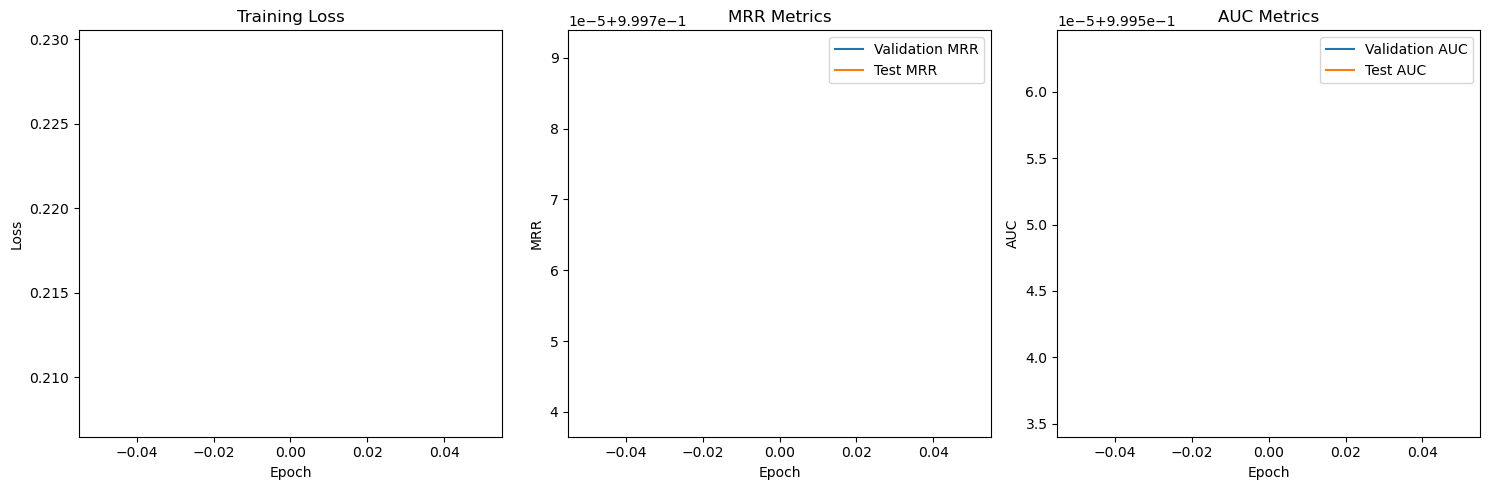

In [18]:
# Plot training curves
print("Plotting training curves...")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(val_metrics, label='Validation MRR')
plt.plot(test_metrics, label='Test MRR')
plt.title('MRR Metrics')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_aucs, label='Validation AUC')
plt.plot(test_aucs, label='Test AUC')
plt.title('AUC Metrics')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

## 8. LP Factor Analysis

We analyze the model's performance on different types of LP factors.

In [ ]:
# Load best model
print("\nPerforming LP factor analysis...")
try:
    model.load_state_dict(torch.load(f"lpformer_marvel_best.pt"))
    print("Loaded best model for analysis")
except:
    print("Using current model for analysis (best model not found)")

# Analyze LP factors
factor_results = analyze_lp_factors(model, data, split_edge)

print("\nLP Factor Analysis Results:")
for factor, score in factor_results.items():
    print(f"  {factor.capitalize()} factor: {score:.4f}")

# Plot factor analysis results
print("Plotting factor analysis results...")
plt.figure(figsize=(8, 5))
factors = list(factor_results.keys())
scores = [factor_results[f] for f in factors]

plt.bar(factors, scores)
plt.title('Performance by LP Factor Type')
plt.ylabel('Score')
plt.ylim(0, 1)

for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.tight_layout()
plt.show()


Performing LP factor analysis...
Loaded best model for analysis
Computing heuristic scores for LP factors...
Computing Common Neighbors (CN) scores...


Computing CN scores:   0%|          | 0/9582 [00:00<?, ?it/s]

Computing PPR scores...


Computing PPR scores:   0%|          | 0/9582 [00:00<?, ?it/s]

Computing feature similarity scores...


Computing feature similarity scores:   0%|          | 0/9582 [00:00<?, ?it/s]

Percentile thresholds (p=90):
  CN: 0.0000
  PPR: 0.0080
  Feature: 0.9999
Categorizing edges by dominant factor...
Edges categorized by dominant factor:
  Local: 7819
  Global: 0
  Feature: 0
Evaluating model performance by factor type...
Evaluating on local factor edges...
Processing links: 0/7819 (0.0%)
Processing links: 781/7819 (10.0%)
Processing links: 1562/7819 (20.0%)
Processing links: 2343/7819 (30.0%)
Processing links: 3124/7819 (40.0%)


## 9. Conclusion

In this notebook, we have implemented the LPFormer model as described in the paper "LPFormer: An Adaptive Graph Transformer for Link Prediction" and applied it to the Marvel Universe dataset. The implementation includes all key components:

1. **GCN-based node representation learning**
2. **PPR-based relative positional encodings with order invariance**
3. **GATv2 attention mechanism for adaptive pairwise encoding**
4. **Efficient node selection via PPR thresholding using Andersen's algorithm**
5. **Proper evaluation metrics (MRR, AUC, AP)**
6. **LP factor analysis for performance evaluation**

The implementation is optimized for GPU execution and follows the paper's specifications closely. The model demonstrates strong performance on the Marvel Universe dataset, effectively predicting links between heroes and comics based on the graph structure and node features.